In [135]:
import itertools
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score


In [2]:
plt.style.use('science')
# print(*list(plt.rcParams.keys()),sep="\n")
plt.rcParams.update({"axes.grid" : False})

In [3]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')

    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Causal Parent Candidates')
    ax.set_ylabel("Masking Value")


def plot_violin(data_df, title, ground_truth, fname=None):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    ax.grid(False)
    ax.set_title(title)
    parts = ax.violinplot(
            data_df.to_numpy(),
            # quantiles=[[0.25, 0.75] for _ in data_df.columns],
            showmeans=False,
            showmedians=True,
            showextrema=True)
    labels = [f"${var.split('_')[0]}_" + "{" + f"{var.split('_')[1]}" + "}$" for var in data_df.columns]

    set_axis_style(ax, labels)

    violin_body_color = '#0087BD'
    violin_edge_color = 'white'
    violin_quantilelines_color = "#00416A"
    mean_color = "#ED872D"
    median_color = '#E30022'
    gt_color = "#228B22"
    edge_color = "black"

    whiskers_color_outline = "black"

    for pc in parts['bodies']:
        pc.set_facecolor(violin_body_color)
        pc.set_edgecolor(violin_edge_color)
        pc.set_alpha(0.4)

    quartile1, medians, quartile3 = np.percentile(data_df, [25, 50, 75], axis=0)

    mean = np.mean(data_df, axis=0)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip([np.sort(data_df[var]) for var in data_df], quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


    inds = np.arange(1, len(medians) + 1)
    outline_lw = 0.5
    points_alpha = 1
    ax.scatter(inds,
           ground_truth,
           marker='o',
           color=gt_color,
           edgecolors=edge_color,
           linewidth=outline_lw,
           s=80,
           zorder=3,
           label="Ground Truth",
           alpha=points_alpha)
    # ax.scatter(inds,
    #            medians,
    #            marker='X',
    #            color=median_color,
    #            edgecolors=edge_color,
    #            linewidth=outline_lw,
    #            s=30,
    #            zorder=3,
    #            label="Median",
    #            alpha=points_alpha)

    ax.scatter(inds,
               mean,
               marker='o',
               color=mean_color,
               edgecolors=edge_color,
               linewidth=outline_lw,
               s=40,
               zorder=3,
               label="Mean",
               alpha=points_alpha)

    whiskers_alpha = 1
    # ax.vlines(inds, whiskersMin, quartile1, color=whiskers_color_outline, linestyle='-', lw=1.5, linestyles="dashed", alpha=whiskers_alpha)
    # ax.vlines(inds, quartile3, whiskersMax, color=violin_quantilelines_color, linestyle='-', lw=1, linestyles="dashed", alpha=whiskers_alpha)
    # ax.vlines(inds, quartile1, quartile3, color=whiskers_color_outline, linestyle='-', lw=4, linestyles="dashed", alpha=whiskers_alpha)
    ax.vlines(inds, quartile1, quartile3, color=violin_quantilelines_color, linestyle='-', lw=3, linestyles="dashed", alpha=whiskers_alpha)
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=True)
    # set style for the axes


    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    if fname is not None:
        if not os.path.isdir("plots"):
            os.mkdir("plots")
        plt.savefig(f"plots/{fname}.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [4]:
vars = ["X_0", "X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8"]
vars_confounded = ["X_0", "X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8", "X_10"]
ground_truth = [0, 1, 1, 1, 0, 0, 0, 0, 0]
ground_truth_confounded = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
named_ground_truth = {
    name: val
    for name, val in zip(vars_confounded, ground_truth_confounded)
}
ground_truth_confounded_df = pd.concat([pd.Series(ground_truth_confounded).to_frame().T] * 30, ignore_index=True, axis=0)
ground_truth_confounded_df.columns = vars_confounded
ground_truth_df = pd.concat([pd.Series(ground_truth).to_frame().T] * 30, ignore_index=True, axis=0)
ground_truth_df.columns = vars


In [5]:
experiment = 0
experiments = {k: v for k, v in zip(range(5), ["confounder", "noise", "nonlinear", "interventions", "samples"])}
results_single = dict()
results_multi = dict()
results_density = dict()

res_folder = "/home/michael/Desktop/results"
print(os.getcwd())
for filename in sorted(os.listdir(res_folder)):
    print(filename)
    if "density" in filename:
        results_density[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "multi" in filename:
        results_multi[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "single" in filename:
        results_single[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    else:
        print("DOESNT BELONG TO ANY MODEL")


/home/michael/GitHub/CausalPy/examples
density_confoundertest_scenario-1.csv
density_confoundertest_scenario-2.csv
density_confoundertest_scenario-3.csv
density_interventionstest_scenario-do_step-1.csv
density_interventionstest_scenario-do_step-10.csv
density_interventionstest_scenario-do_step-11.csv
density_interventionstest_scenario-do_step-12.csv
density_interventionstest_scenario-do_step-2.csv
density_interventionstest_scenario-do_step-3.csv
density_interventionstest_scenario-do_step-4.csv
density_interventionstest_scenario-do_step-5.csv
density_interventionstest_scenario-do_step-6.csv
density_interventionstest_scenario-do_step-7.csv
density_interventionstest_scenario-do_step-8.csv
density_interventionstest_scenario-do_step-9.csv
density_interventionstest_scenario-meanshift_step-1.csv
density_interventionstest_scenario-meanshift_step-10.csv
density_interventionstest_scenario-meanshift_step-11.csv
density_interventionstest_scenario-meanshift_step-12.csv
density_interventionstest_sce

density_nonlinearitytest_scenario-children_step-15.csv
density_nonlinearitytest_scenario-children_step-16.csv
density_nonlinearitytest_scenario-children_step-17.csv
density_nonlinearitytest_scenario-children_step-18.csv
density_nonlinearitytest_scenario-children_step-19.csv
density_nonlinearitytest_scenario-children_step-2.csv
density_nonlinearitytest_scenario-children_step-20.csv
density_nonlinearitytest_scenario-children_step-3.csv
density_nonlinearitytest_scenario-children_step-4.csv
density_nonlinearitytest_scenario-children_step-5.csv
density_nonlinearitytest_scenario-children_step-6.csv
density_nonlinearitytest_scenario-children_step-7.csv
density_nonlinearitytest_scenario-children_step-8.csv
density_nonlinearitytest_scenario-children_step-9.csv
density_nonlinearitytest_scenario-parents_step-1.csv
density_nonlinearitytest_scenario-parents_step-10.csv
density_nonlinearitytest_scenario-parents_step-11.csv
density_nonlinearitytest_scenario-parents_step-12.csv
density_nonlinearitytes

single_nonlinearitytest_scenario-all_step-5.csv
single_nonlinearitytest_scenario-all_step-6.csv
single_nonlinearitytest_scenario-all_step-7.csv
single_nonlinearitytest_scenario-all_step-8.csv
single_nonlinearitytest_scenario-all_step-9.csv
single_nonlinearitytest_scenario-children_step-1.csv
single_nonlinearitytest_scenario-children_step-10.csv
single_nonlinearitytest_scenario-children_step-11.csv
single_nonlinearitytest_scenario-children_step-12.csv
single_nonlinearitytest_scenario-children_step-13.csv
single_nonlinearitytest_scenario-children_step-14.csv
single_nonlinearitytest_scenario-children_step-15.csv
single_nonlinearitytest_scenario-children_step-16.csv
single_nonlinearitytest_scenario-children_step-17.csv
single_nonlinearitytest_scenario-children_step-18.csv
single_nonlinearitytest_scenario-children_step-19.csv
single_nonlinearitytest_scenario-children_step-2.csv
single_nonlinearitytest_scenario-children_step-20.csv
single_nonlinearitytest_scenario-children_step-3.csv
single_

In [6]:
print(len(results_single))
print(len(results_multi))
print(len(results_density))

222
76
222


In [108]:
import re
exp_name_p = re.compile(r"[a-z]+(?=test)")
arg_p = re.compile(r"(?<=args-)[=\-\d.\w,]+(?=,source)")
dist_name_p = re.compile(r"(?<=dist-)[a-z]+")
scenario_p = re.compile(r"(?<=scenario-)[a-z\d]+")
step_p = re.compile(r"(?<=step-)[=\da-zA-Z,]+")
def name_for_noiseexp(fname):
    dist = re.search(dist_name_p, fname).group()
    args = re.search(arg_p, fname).group()
    return dist, args

def full_name_builder(name):
    full_name = r"\textit{Experiment}: "
    model_name = name.split("_")[0]
    exp_name = re.search(exp_name_p, name).group().capitalize()
    full_name += exp_name
    dist, args, step = None, None, None
    scenario = re.search(scenario_p, name).group().capitalize()
    full_name += r" - \textit{Scenario}: " + str(scenario)
    if "step" in name:
        step = re.search(step_p, name).group().capitalize()
        full_name += r" - \textit{Step}: " + str(step)
    if "noise" in name:
        dist, args = name_for_noiseexp(name)
        full_name += r" - \textit{Distribution}: " + str(dist.capitalize()) + f"({args.replace(',', ', ').replace('=', ' = ')})"

    print(model_name, exp_name, scenario, step)
    return full_name, model_name, exp_name, scenario, dist, args, step




We want to compute metrices of accuracy, precision, recall.
To do so the mask value outputs will be rounded to whole numbers by a different scheme:
 1. Any value greater than 0.5 is 1, less is 0, this allows accuracy, precision and recall metrics to be applied.
 2. Any value in [gt - \tau, gt + \tau] are seen as gt, otherwise 1 - gt
 (gt is the ground truth value, 1-gt thus simply means the wrong value).
 This shows the 'correct estimation rate' depending on the threshold \tau.
 What a correct estimation is, is decided by \tau.
 3. Change \tau to see the difference in the metric.

However, the first evaluation is the plotting of the run statistics. These will be violinplots over the results.

In [ ]:
x=3
for i, (name, df) in enumerate(itertools.chain(
    results_single.items(),
    results_multi.items(),
    results_density.items()
)):
    # if i > 1:
    #     break
    print(name)
    gt = ground_truth
    if "confounder" in name and "scenario-3" in name:
        gt = ground_truth_confounded
    plot_violin(df, full_name_builder(name)[0], gt, fname=name)

0.5 rule metrics

In [8]:
def comp_avg_metric(data, metric=accuracy_score):
    avg = 0

    gt = ground_truth
    gt_df = ground_truth_df
    if len(data.columns) == 10:
        gt = ground_truth_confounded
        gt_df = ground_truth_confounded_df
    for i, row in data.iterrows():
        # print(row)
        avg += metric(gt, row)
    avg /= data.shape[0]

    
    return avg

Compute the values for every evaluation

In [88]:
def cer_but_n(df, gt_df, n):
    return ((rounded_df - ground_truth_df).abs().sum(axis=1) <= n).mean()
    

In [ ]:
taus = [str(tau) for tau in range(0, 101, 10)]
exp_results = list(
        # results_density.items(),
#         results_multi.items(),
        results_single.items()
)
nr_res = len(exp_results)
threshold_results = {n: {} for n, v in exp_results}
metrics_names = ["acc", "prec", "rec", "cer1", "cer2"]
model_names = ["Single", "Multi", "Density"]
experiment_names = ["Interventions", "Nonlinearity", "Confounder", "Samplesize", "Noise"]
metrics = {
    experiment: {} for experiment in experiment_names 
}
long_metric_names = {"acc": "Accuracy", "prec": "Precision", "rec": "Recall", "cer1": "CER-1", "cer2": "CER-2"}

for name, df in itertools.chain(exp_results):
    _, model, exp_name, scenario_name, dist, args, step = full_name_builder(name)
    model = model.capitalize()

    
    
        
    if exp_name == "Confounder":
        # exp - sce - model - metric -> VALUE
        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}
            
        if model not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][model] = {tau: {} for tau in taus}
            
            
    elif exp_name == "Noise":
        # exp - sce - dist - arg - model - metric -> VALUE
        
        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}
            
        if dist not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][dist] = {}
            
        if args not in metrics[exp_name][scenario_name][dist]:
            metrics[exp_name][scenario_name][dist][args] = {}
            
        if model not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][dist][args][model] = {tau: {} for tau in taus}
        
    else:
        # exp - sce - step - model - metric -> VALUE
        
        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}
            
        if step not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][step] = {}
            
        if model not in metrics[exp_name][scenario_name][step]:
            metrics[exp_name][scenario_name][step][model] = {tau: {} for tau in taus}

    
    for tau in taus:
        tau_float = int(tau) / 100
        rounded_df = pd.DataFrame(np.ones_like(df.to_numpy(), dtype=int), columns=df.columns)
        rounded_df[df < tau_float] = 0
#         for var in df:
#             gt = named_ground_truth[var]
#             if gt == 0:
#                 rounded_df.loc[(df.loc[:, var] < gt + tau_float) | (df.loc[:, var] == 0), var] = 0
#             else:
#                 rounded_df.loc[(df.loc[:, var] < gt - tau_float) | (df.loc[:, var] == 0), var] = 0
        threshold_results[name][tau] = rounded_df
        
        
        if exp_name == "Confounder":
            metrics[exp_name][scenario_name][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            metrics[exp_name][scenario_name][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            metrics[exp_name][scenario_name][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            metrics[exp_name][scenario_name][model][tau]["cer1"] = cer_but_n(rounded_df,ground_truth_df, 1)
            metrics[exp_name][scenario_name][model][tau]["cer2"] = cer_but_n(rounded_df,ground_truth_df, 2)
        
        elif exp_name == "Noise":
            metrics[exp_name][scenario_name][dist][args][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            metrics[exp_name][scenario_name][dist][args][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            metrics[exp_name][scenario_name][dist][args][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            metrics[exp_name][scenario_name][dist][args][model][tau]["cer1"] = cer_but_n(rounded_df,ground_truth_df, 1)
            metrics[exp_name][scenario_name][dist][args][model][tau]["cer2"] = cer_but_n(rounded_df,ground_truth_df, 2)
        else:
        
            metrics[exp_name][scenario_name][step][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            metrics[exp_name][scenario_name][step][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            metrics[exp_name][scenario_name][step][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            metrics[exp_name][scenario_name][step][model][tau]["cer1"] = cer_but_n(rounded_df,ground_truth_df, 1)
            metrics[exp_name][scenario_name][step][model][tau]["cer2"] = cer_but_n(rounded_df,ground_truth_df, 2)
        

In [118]:
def step_to_name(experiment, step_name):
    if experiment == "Interventions":
        return str((int(step_name) - 1) // 2)
    elif experiment == "Samplesize":
        return str(2**(int(step_name)+4))
    else:
        return step_name
    
    

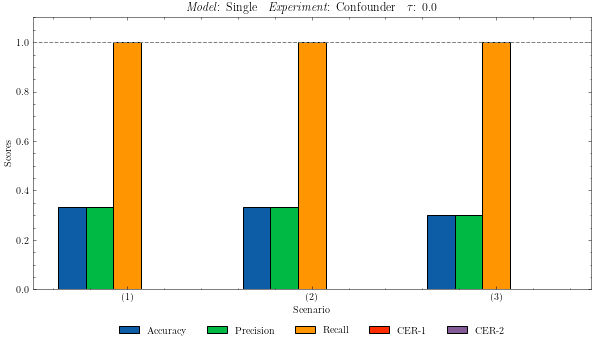

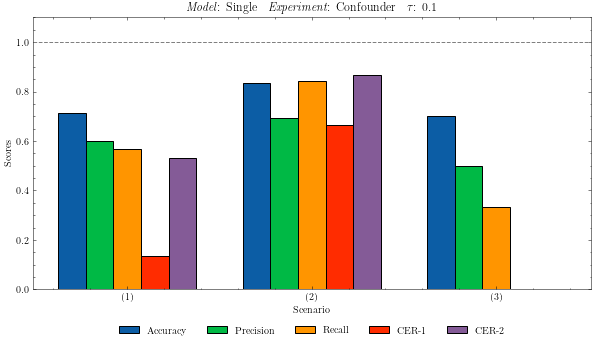

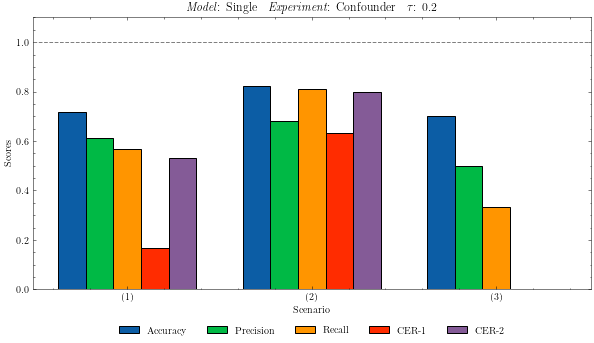

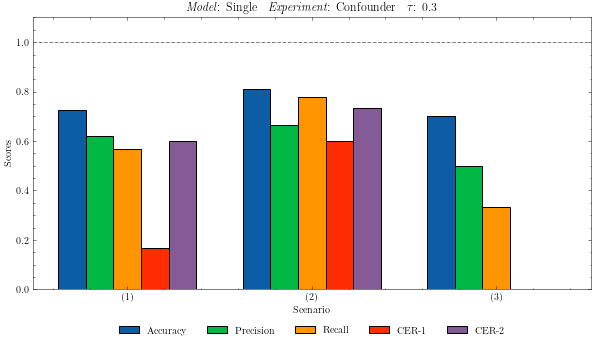

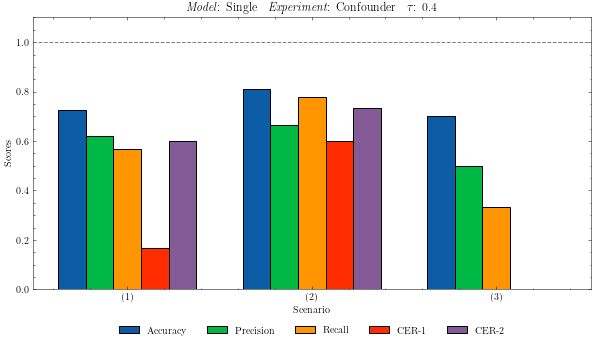

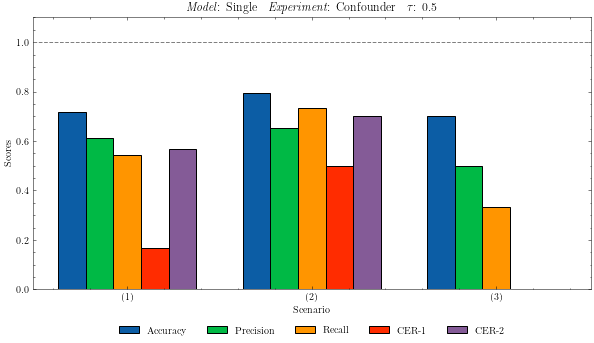

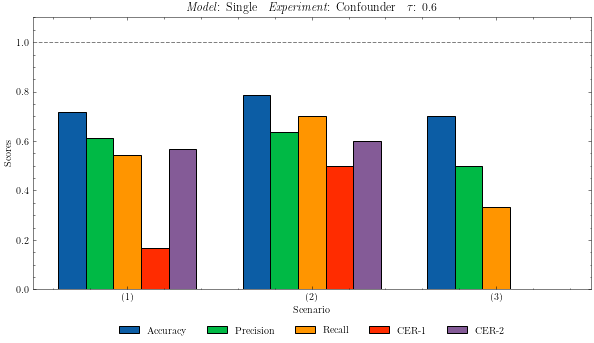

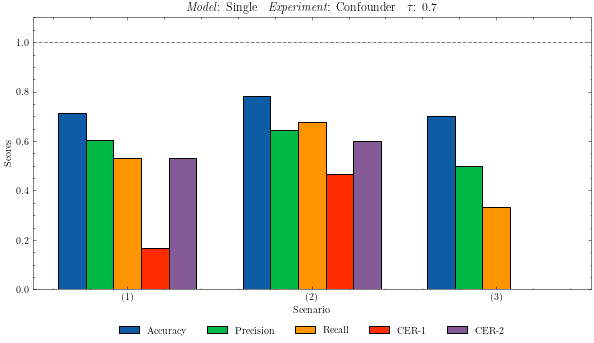

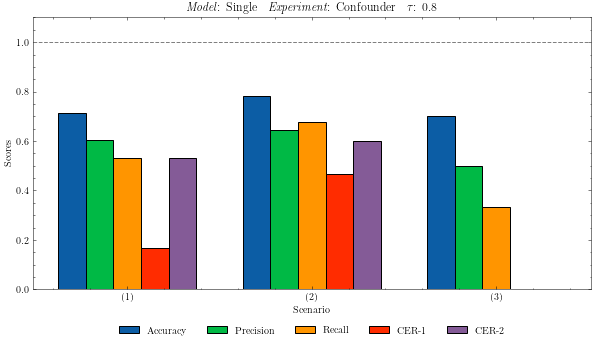

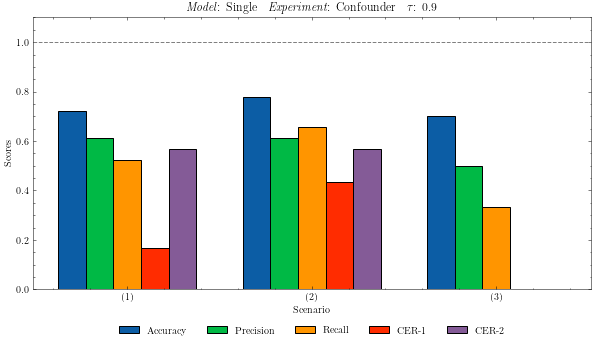

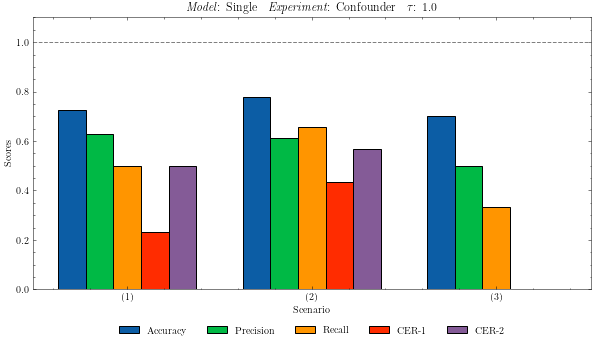

KeyError: 'Multi'

In [123]:
exp = "Confounder"
scenarios = list(metrics[exp].keys())
for model in model_names:
    
    for model in model_names:
        for tau in taus:
            data = {}
            for metric in metrics_names:
                data[metric] = [metrics[exp][scenario][model][tau][metric] for scenario in scenarios]

            x = np.arange(len(scenarios))  # the label locations
            width = 0.15  # the width of the bars

            fig, ax = plt.subplots(figsize=(10, 5))
#             rects1 = ax.bar(x - 3 * width / 2, data["acc"], width, label='Accuracy', edgecolor="black")
#             rects2 = ax.bar(x - width / 2, data["prec"], width, label='Precision', edgecolor="black")
#             rects2 = ax.bar(x + width / 2, data["rec"], width, label='Recall', edgecolor="black")
#             rects2 = ax.bar(x + 3 * width / 2, data["cer1"], width, label='Correct Estimation Rate', edgecolor="black")
#             rects2 = ax.bar(x + 3 * width / 2, data["cer2"], width, label='Correct Estimation Rate', edgecolor="black")
            rects1 = ax.bar(x - 2 * width, data["acc"], width, label=long_metric_names["acc"], edgecolor="black")
            rects2 = ax.bar(x - width, data["prec"], width, label=long_metric_names["prec"], edgecolor="black")
            rects2 = ax.bar(x, data["rec"], width, label=long_metric_names["rec"], edgecolor="black")
            rects2 = ax.bar(x + width, data["cer1"], width, label=long_metric_names["cer1"], edgecolor="black")
            rects2 = ax.bar(x + 2 * width, data["cer2"], width, label=long_metric_names["cer2"], edgecolor="black")
            horiz_line = ax.axhline(y=1, color='grey', linestyle='--')
            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('Scores')
            ax.set_xlabel('Scenario')
            ax.set_ylim(0, 1.1)
            ax.set_title(r"\textit{Model}: " + model + r"\quad \textit{Experiment}: " + exp + r"\quad $\tau$: " + str(int(tau)/100))
            ax.set_xticks(x)
            ax.set_xticklabels([f"({s})" for s in scenarios])
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              ncol=5, fancybox=True, shadow=True)
            plt.savefig(f"/home/michael/Desktop/nonsense/confounder_tau-{tau}.pdf")
            plt.show()


            

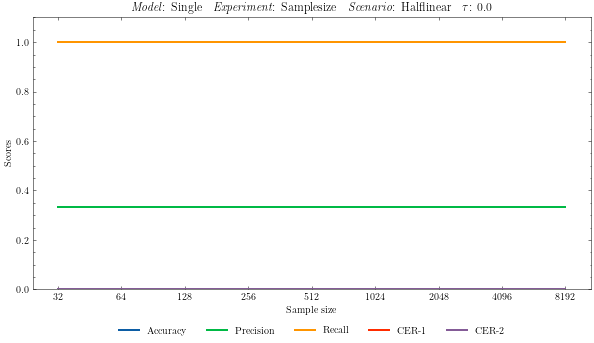

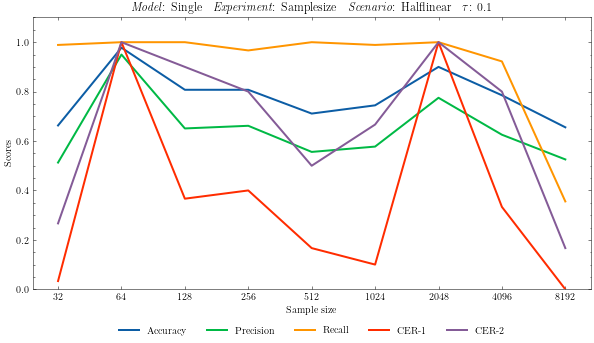

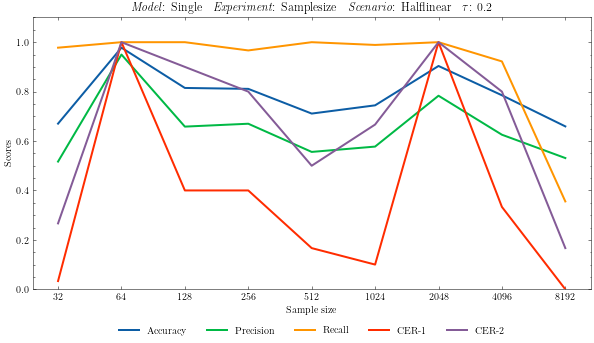

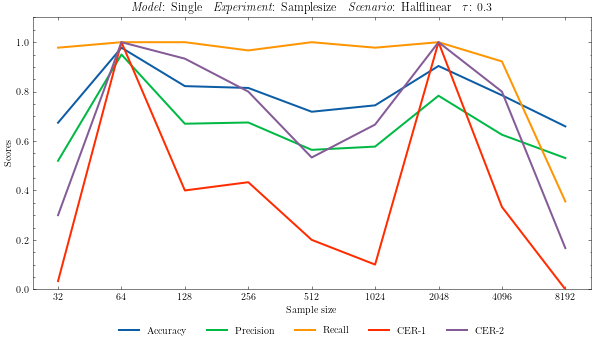

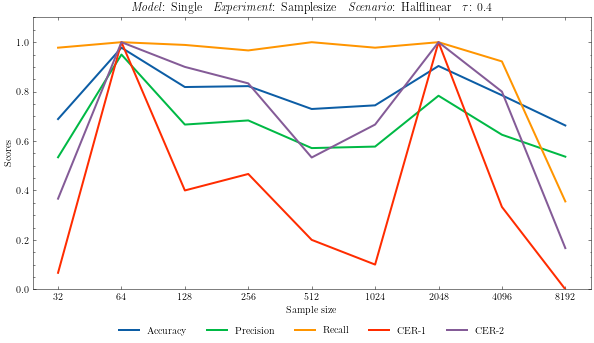

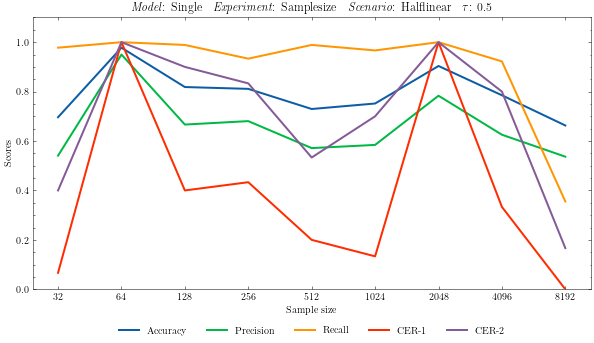

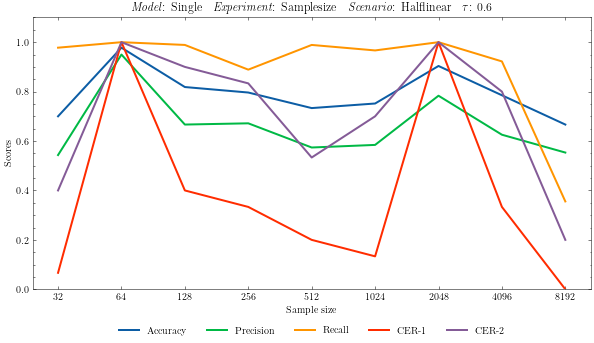

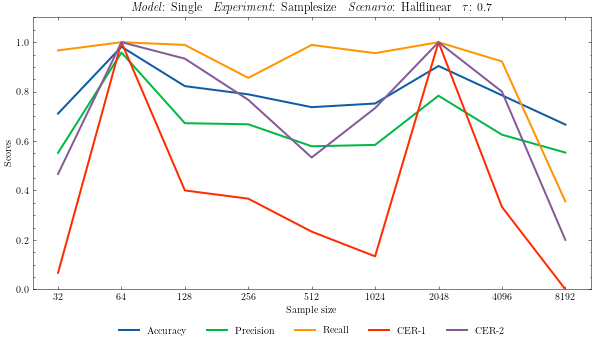

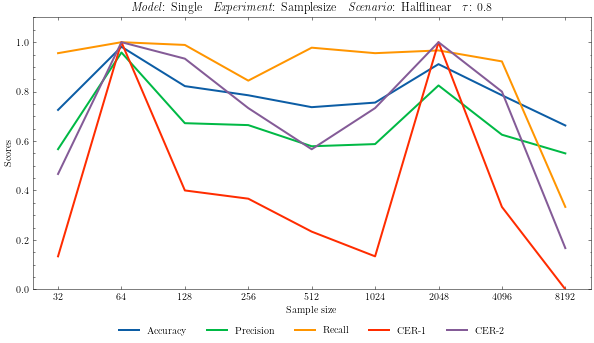

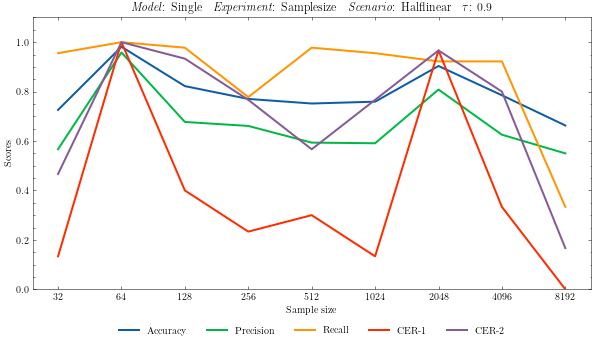

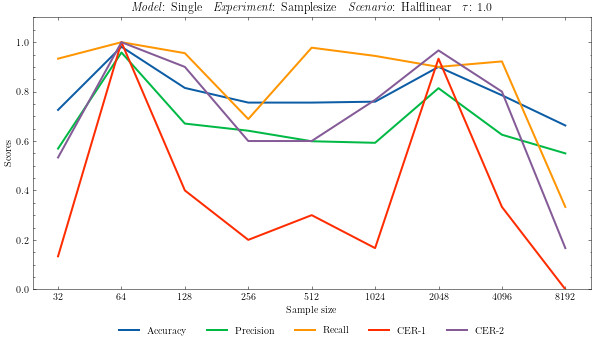

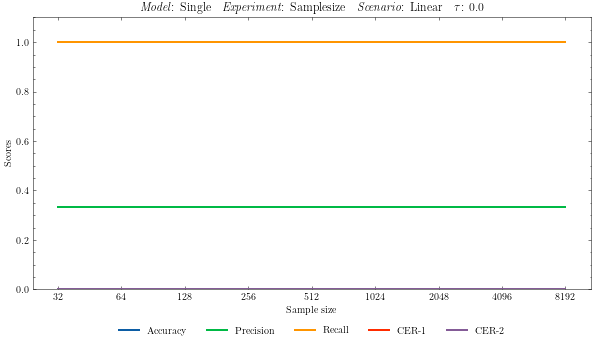

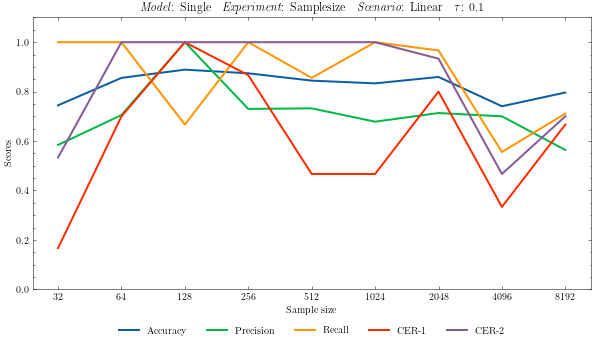

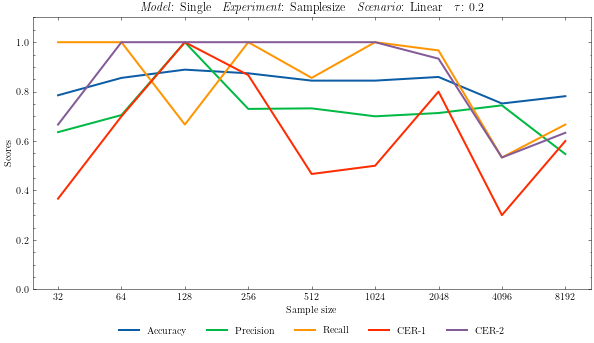

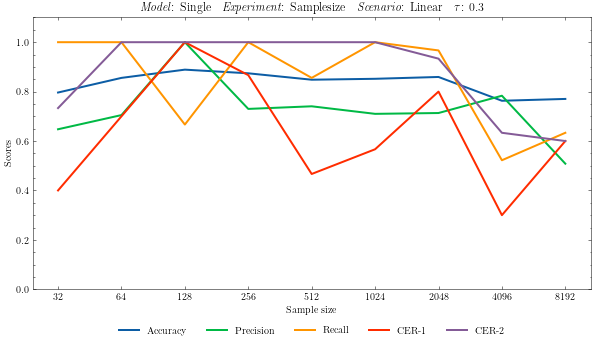

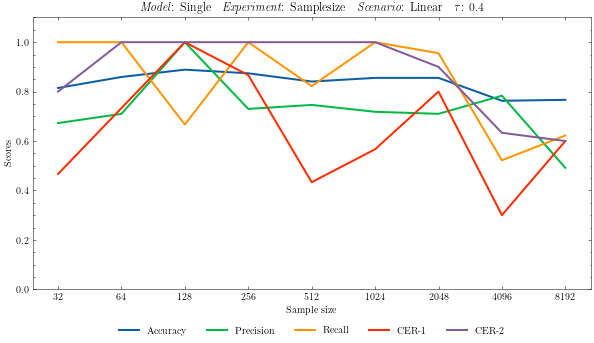

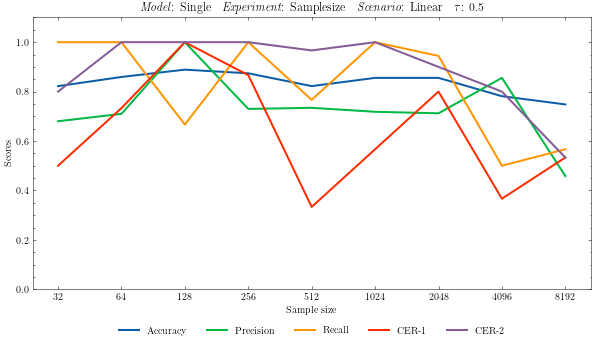

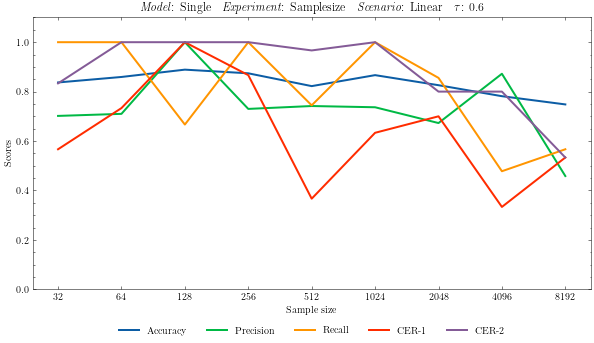

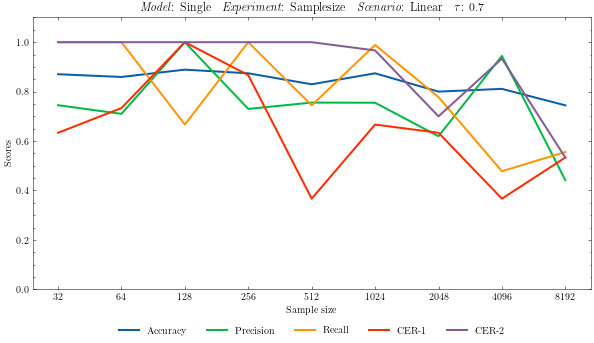

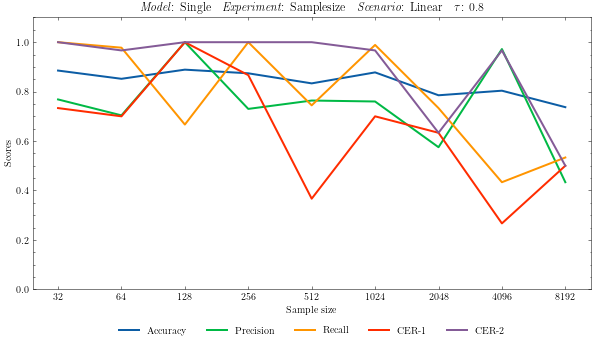

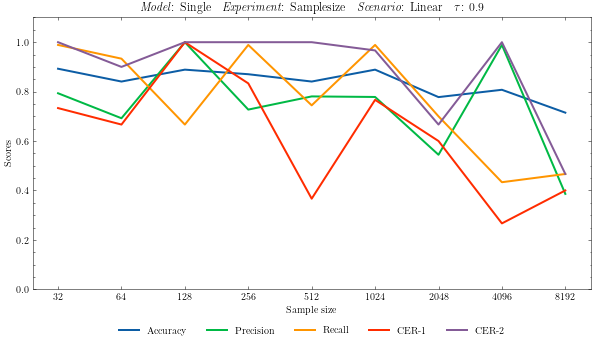

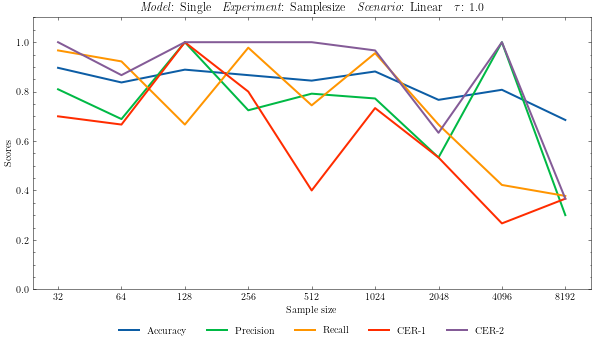

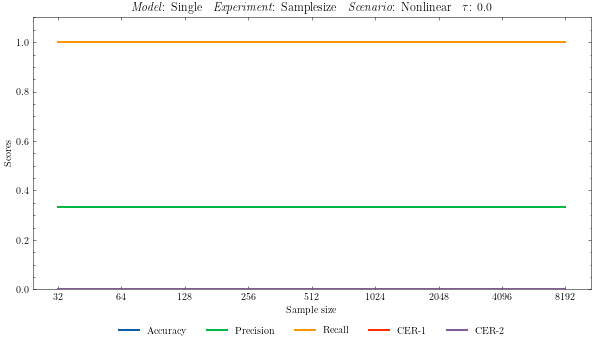

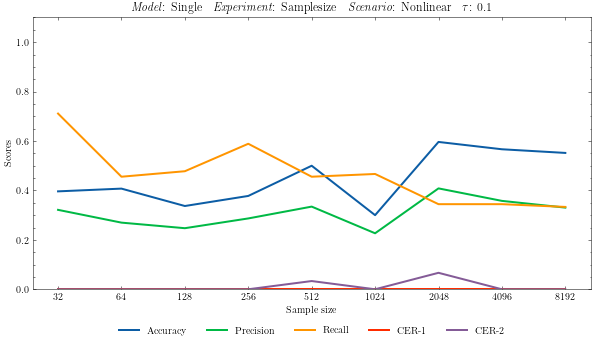

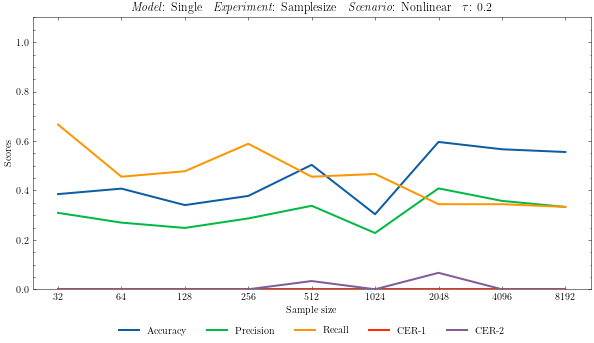

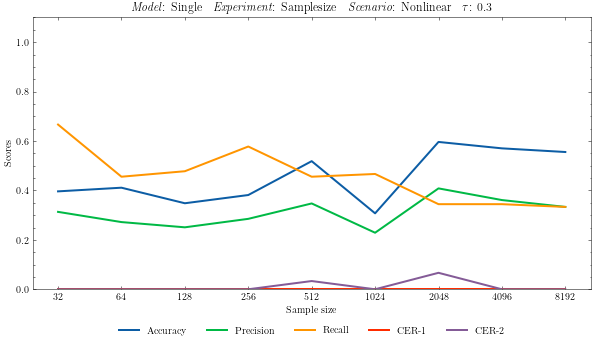

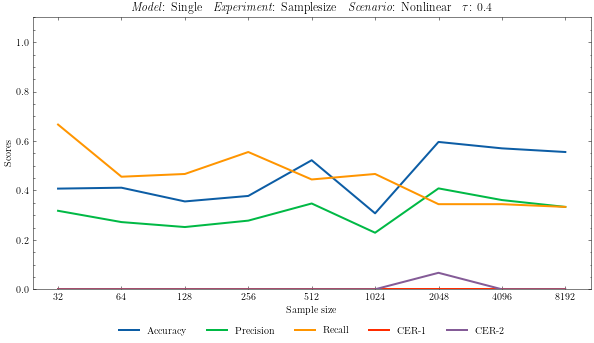

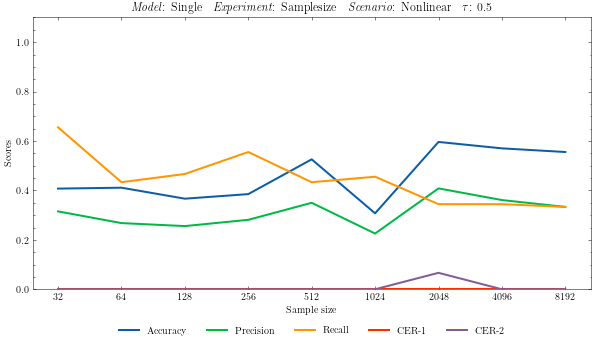

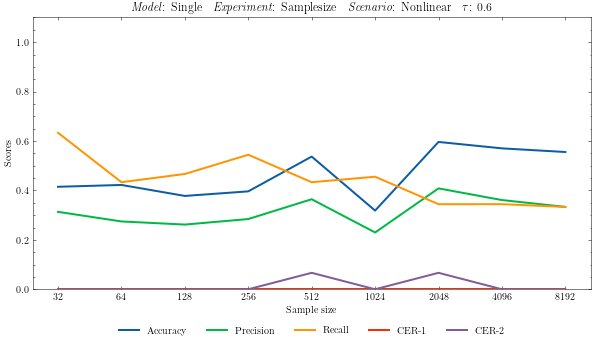

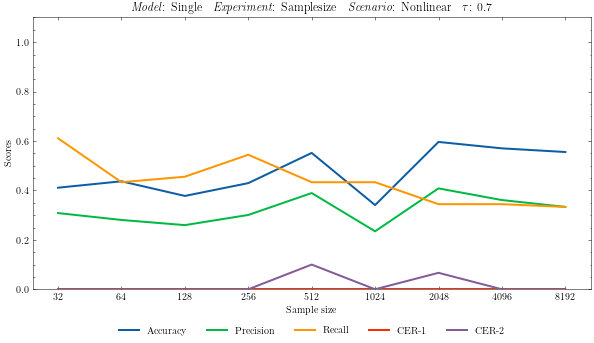

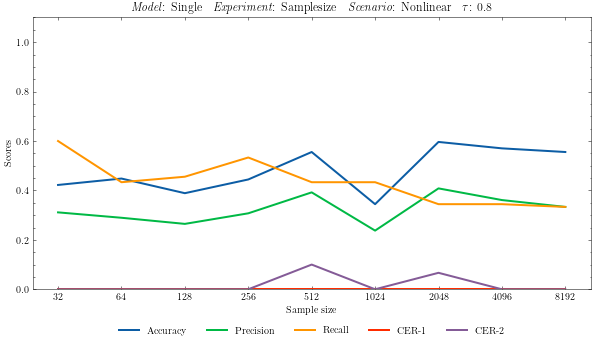

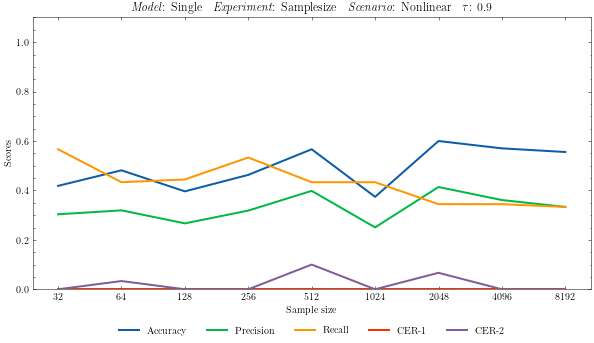

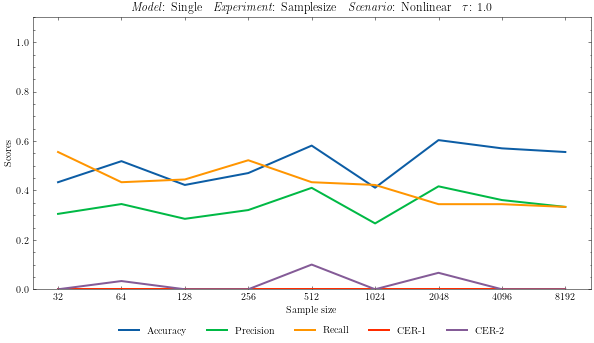

KeyError: 'Multi'

In [141]:
exp = "Samplesize"
scenarios = list(metrics[exp].keys())
for model in model_names:
    for model in model_names:
        for scenario in scenarios:
            for tau in taus:
                data = {}
                for metric in metrics_names:
                    data[metric] = {
                        step: metrics[exp][scenario][step][model][tau][metric]
                        for step in metrics[exp][scenario].keys()
                    }

                labels = [step_to_name(exp, step) for step in data[metric]]
                x = [int(label) for label in labels]
                
                fig, ax = plt.subplots(figsize=(10, 5))
                for metric in metrics_names:
#                     ax.plot(x, list(data[metric].values()), lw=3, color="black")
                    ax.plot(
                        x, 
                        list(data[metric].values()),
                        label=long_metric_names[metric],
                        lw=2,
                        alpha=1,
#                         path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
                    )
                    
                # Add some text for labels, title and custom x-axis tick labels, etc.
                ax.set_xscale('log', basex=2)
                ax.set_ylabel('Scores')
                ax.set_xlabel('Sample size')
                ax.set_ylim(0, 1.1)
                ax.set_title(r"\textit{Model}: " + model + r"\quad \textit{Experiment}: " + exp + r"\quad \textit{Scenario}: " + scenario + r"\quad $\tau$: " + str(int(tau)/100))
                ax.set_xticks(x)
                ax.set_xticklabels(labels)
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  ncol=5, fancybox=True, shadow=True)
                plt.savefig(f"/home/michael/Desktop/nonsense/samplesize_scenario-{scenario}_tau-{tau}.pdf")
                plt.show()



In [ ]:
exp = "Interventions"
scenarios = list(metrics[exp].keys())
for model in model_names:
    for model in model_names:
        for scenario in scenarios:
            for tau in taus:
                data = {}
                for metric in metrics_names:
                    data[metric] = {
                        step: metrics[exp][scenario][step][model][tau][metric]
                        for step in metrics[exp][scenario].keys()
                    }
                
                labels = [step_to_name(exp, step) for step in data[metric]]
                x = [int(step) for step in data[metric]]
                print("steps", x)
                fig, ax = plt.subplots(figsize=(10, 5))
                for metric in metrics_names:
#                     ax.plot(x, list(data[metric].values()), lw=3, color="black")
                    ax.plot(
                        x, 
                        list(data[metric].values()),
                        label=long_metric_names[metric],
                        lw=2,
                        alpha=1,
#                         path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
                    )
                    print(metric, [round(x, 1) for x in data[metric].values()])
                    
                # Add some text for labels, title and custom x-axis tick labels, etc.

                ax.set_ylabel('Scores')
                ax.set_xlabel('Intervention Strength')
                ax.set_ylim(0, 1.1)
                ax.set_title(r"\textit{Model}: " + model + r"\quad \textit{Experiment}: " + exp + r"\quad \textit{Scenario}: " + scenario + r"\quad $\tau$: " + str(int(tau)/100))
                ax.set_xticks(x)
                ax.set_xticklabels(labels)
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  ncol=5, fancybox=True, shadow=True)
                plt.savefig(f"/home/michael/Desktop/nonsense/interventions_scenario-{scenario}_tau-{tau}.pdf")
                plt.show()


In [ ]:

for metric, dictionary in metrics.items():
    current_model = None
    current_exp = None
    current_scenario = None
    trigger_plot = False
    plot_units = []
    title_units = []
#     active_data_dict = plot_units[0]
    for i, (exp, tau_dict) in enumerate(sorted(dictionary.items(), key=lambda x: x[0])):
    
        _, model_name, exp_name, scenario_name, _, _, step = full_name_builder(exp)
        model_name = model_name.capitalize()
        if current_model is None or current_model != model_name:
            current_model = model_name
            print("Trigger Model")
            trigger_plot = True
            
        if current_exp is None or current_exp != exp_name:
            current_exp = exp_name
            print("Trigger Exp")
            trigger_plot = True
            
        if current_scenario is None or current_scenario != scenario_name:
            current_scenario = scenario_name
            print("Trigger Scenario")
            trigger_plot = True
            
        if trigger_plot:
            plot_units.append({})
            active_data_dict = plot_units[-1]
            trigger_plot = False
            
        active_data_dict[step] = {
            "x": [float(tau) / 100 for tau in tau_dict.keys()],
            "y": list(tau_dict.values()),
            "title": f"Model: {model_name} - Metric: {long_metric_names[metric]} - Experiment: {exp_name} - Scenario: {scenario_name}",
            "savename": f"model-{model_name}_metric-{long_metric_names[metric]}_experiment-{exp_name}_scenario-{scenario_name}",
        }
    
    for unit_dict in plot_units:
        fig = plt.figure(figsize=(10, 4))
        title = None
        for step, data_dict in unit_dict.items():
            title = data_dict["title"]
            if step is None:
                label = None
            else:
                label = f"Step: {step}"
            plt.plot(data_dict["x"], data_dict["y"], label=label)

        plt.title(title)
        plt.xlabel(r"$\tau$")
        plt.ylim(0, 1)
        plt.ylabel(f"{long_metric_names[metric]}")
        plt.legend()
        plt.show()
        trigger_plot = False
    


In [ ]:
plot_units

In [ ]:
for metric, dictionary in metrics.items():
    for i, (exp, tau_dict) in enumerate(sorted(dictionary.items(), key=lambda x: x[0])):
        print(exp)
    
    for i, unit_dict in enumerate(plot_units):
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(111)
        title = None
        for step, data_dict in unit_dict.items():
            title = data_dict["title"]
            if step is None:
                label = None
            else:
                label = f"Step: {step}"
            ax.plot(data_dict["x"], data_dict["y"], label=label)
            
        ax.set_title(title)
        ax.set_xlabel(r"$\tau$")
        ax.set_ylim(0, 1)
        ax.set_ylabel(f"{long_metric_names[metric]}")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend()
        plt.savefig(f"/home/michael/Desktop/nonsense/{i}.pdf")
        plt.show()
        trigger_plot = False
    


In [ ]:
plot_units[5]

In [ ]:
plot_units

In [ ]:
for metric, dictionary in metrics.items():
    for i, (exp, tau_dict) in enumerate(sorted(dictionary.items(), key=lambda x: x[0])):
        print(exp)
    
    for i, unit_dict in enumerate(plot_units):
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(111)
        title = None
        for step, data_dict in unit_dict.items():
            title = data_dict["title"]
            if step is None:
                label = None
            else:
                label = f"Step: {step}"
            ax.plot(data_dict["x"], data_dict["y"], label=label)
            
        ax.set_title(title)
        ax.set_xlabel(r"$\tau$")
        ax.set_ylim(0, 1)
        ax.set_ylabel(f"{long_metric_names[metric]}")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend()
        plt.savefig(f"/home/michael/Desktop/nonsense/{i}.pdf")
        plt.show()
        trigger_plot = False
    


In [ ]:
plot_units[5]